In [192]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [193]:
train_df = pd.read_csv('./data/pp5i_train.gr.csv')
test_df = pd.read_csv('./data/pp5i_test.gr.csv')
class_df = pd.read_csv('./data/pp5i_train_class.txt')

In [194]:
class_np = class_df.to_numpy()

le = preprocessing.LabelEncoder()
le.fit(np.ravel(class_np))
train_class = le.transform(np.ravel(class_np))

In [195]:
print(train_class)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 3 3 3 3 3 3 3 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]


### Step 1. Data Cleaning

In [196]:
#Threshold both train and test data to a minimum value of 20, maximum of 16,000.#


train_df=train_df.iloc[:,1:].clip(20,16000)


test_df=test_df.iloc[:,1:].clip(20,16000)


### Step 2. Selecting top genes by class

In [197]:
#Remove from train data genes with fold differences across samples less than 2.#
train_cal = abs(train_df.max(axis=1)/train_df.min(axis=1))
del_ind = train_cal[train_cal<2].index
train_df=train_df.drop(del_ind)

In [198]:
#perform ANOVA
train_temp = train_df.T


In [199]:
from sklearn.feature_selection import f_classif
new_train = f_classif(train_temp,train_class)
train_df['rank'] = new_train[0]
train_df=train_df.sort_values('rank',ascending=False)


In [200]:
#For N combine top genes for each class into one file and removing duplicates#
N = [2,4,6,8,10,12,15,20,25,30]
train_df=train_df.drop('rank',axis=1)
classes = np.unique(class_df.values)
for n in N:
    top_genes = set()
    top_genes.update(train_df.head(n).index.tolist())
    pd.concat([train_df.loc[list(top_genes), :].T.reset_index(drop=True), class_df],
                  axis=1).to_csv('pp5i_train.top'+str(n)+'.gr.csv', index=False)


## Step 3. Find the best classifier/best gene set combination

In [201]:
for n in N:
    globals()['x_train%s' % n] = pd.read_csv('pp5i_train.top'+str(n)+'.gr.csv').drop(labels='Class', axis=1).values.tolist()
    globals()['y_train%s' % n] = le.transform(np.ravel(pd.read_csv('pp5i_train.top'+str(n)+'.gr.csv', usecols=['Class']).values.tolist()))

Naïve Bayes (Gaussian Naive Bayes)

N=2 error rate: 0.73 
N=4 error rate: 0.45 
N=6 error rate: 0.38 
N=8 error rate: 0.44 
N=10 error rate: 0.48 
N=12 error rate: 0.42 
N=15 error rate: 0.32 
N=20 error rate: 0.26 
N=25 error rate: 0.23 
N=30 error rate: 0.22 


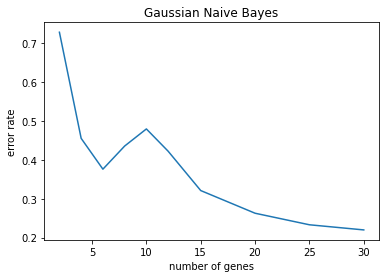

In [202]:
def search_gene(clf):
    best_score = 0
    accuracy = []
    for n in N:
        scores = cross_val_score(clf, globals()['x_train%s'%n], globals()['y_train%s'%n], cv=5, n_jobs=-1)
        score = 1- scores.mean()
        accuracy.append(score)
        print("N=%d error rate: %0.2f " % (n, score))
        best_n = n if score > best_score else best_n
        best_score = score if score > best_score else best_score
    return best_n, accuracy

best_n, scores = search_gene(GaussianNB())

def draw(scores, name):
    plt.plot(N, scores)
    plt.xlabel('number of genes')
    plt.ylabel('error rate')
    plt.title(name)
    plt.show()
    
draw(scores, 'Gaussian Naive Bayes')

Decision tree (J48 algorithm)

N=2 error rate: 0.32 
N=4 error rate: 0.25 
N=6 error rate: 0.31 
N=8 error rate: 0.25 
N=10 error rate: 0.22 
N=12 error rate: 0.19 
N=15 error rate: 0.07 
N=20 error rate: 0.12 
N=25 error rate: 0.15 
N=30 error rate: 0.09 


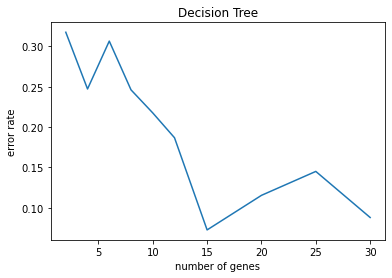

In [18]:
from sklearn.tree import DecisionTreeClassifier

best_n, scores = search_gene(DecisionTreeClassifier(class_weight='balanced',max_depth=30))

draw(scores, 'Decision Tree')

K-NN

N=2:
GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4]})
N=4:
GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4]})
N=6:
GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4]})
N=8:
GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4]})
N=10:
GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4]})
N=12:
GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4]})
N=15:
GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4]})
N=20:
GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4]})
N=25:
GridSearchCV(cv=5, est

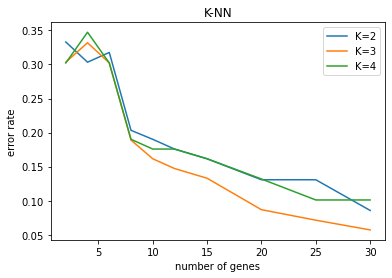

Best Params: N=30, K=3


In [23]:
from sklearn.neighbors import KNeighborsClassifier

KNNclf = KNeighborsClassifier()

params = {
    'n_neighbors': [2, 3, 4]
}

best_score = 0
accuracy = []
for n in N:
    cv = GridSearchCV(KNNclf, params, cv=5, n_jobs=-1)
    cv.fit(globals()['x_train%s'%n], globals()['y_train%s'%n])
    score = max(cv.cv_results_['mean_test_score'])
    accuracy.append(list(1-cv.cv_results_['mean_test_score']))
    best_n = n if score > best_score else best_n
    best_K = cv.best_params_['n_neighbors'] if score > best_score else best_K
    best_score = score if score > best_score else best_score
    print('N=%s:'%n)
    print(cv)

accuracy = np.array(accuracy)
plt.plot(N, accuracy[:, 0], label='K=2')
plt.plot(N, accuracy[:, 1], label='K=3')
plt.plot(N, accuracy[:, 2], label='K=4')
plt.xlabel('number of genes')
plt.ylabel('error rate')
plt.title('K-NN')
plt.legend()
plt.show()

print('Best Params: N=%d, K=%d' % (best_n, best_K))

Neural network

N=2 error rate: 0.39 
N=4 error rate: 0.35 
N=6 error rate: 0.30 
N=8 error rate: 0.20 
N=10 error rate: 0.17 
N=12 error rate: 0.17 
N=15 error rate: 0.16 
N=20 error rate: 0.09 
N=25 error rate: 0.11 
N=30 error rate: 0.10 


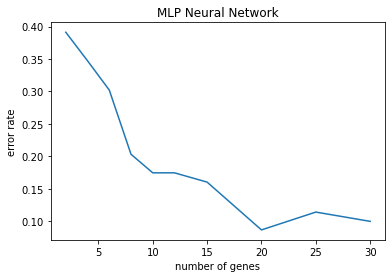

In [27]:
from sklearn.neural_network import MLPClassifier

NNclf = MLPClassifier(hidden_layer_sizes=100,activation='logistic')
best_n, scores = search_gene(NNclf)

draw(scores, 'MLP Neural Network')

ExtraTreesClassifier

N=2 error rate: 0.32 
N=4 error rate: 0.25 
N=6 error rate: 0.27 
N=8 error rate: 0.16 
N=10 error rate: 0.16 
N=12 error rate: 0.13 
N=15 error rate: 0.07 
N=20 error rate: 0.06 
N=25 error rate: 0.07 
N=30 error rate: 0.04 


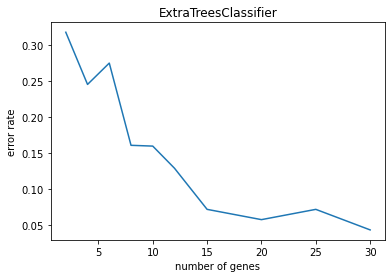

In [206]:
from sklearn.ensemble import ExtraTreesClassifier

ETclf = ExtraTreesClassifier(n_estimators=200)
best_n, scores = search_gene(ETclf)

draw(scores, 'ExtraTreesClassifier')

Convert test set to genes-in-columns format to prepare it for classification

In [203]:
best_n = 30

best_gene=pd.read_csv('pp5i_train.top'+str(best_n)+'.gr.csv').drop(labels='Class',axis=1).columns.tolist()
for i in range(0, len(best_gene)):
    best_gene[i] = int(best_gene[i])
y_test = test_df.loc[best_gene,: ].reset_index(drop=True)
y_test =y_test.T

In [204]:
pd.read_csv('pp5i_train.top'+str(best_n)+'.gr.csv').to_csv('pp5i_train.bestN.csv', index=False)
y_test.to_csv('pp5i_test.bestN.csv', index=False)

## Step 4. Generate predictions for the test set 

In [208]:
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

x_train = pd.read_csv('pp5i_train.bestN.csv').drop(labels='Class', axis=1).values.tolist()
y_train = le.transform(np.ravel(pd.read_csv('pp5i_train.bestN.csv', usecols=['Class']).values.tolist()))


clf = ExtraTreesClassifier(n_estimators=200)
clf.fit(x_train, y_train)
np.savetxt('pp5i_test_class.txt', le.inverse_transform(clf.predict(y_test)), fmt='%s')


In [209]:
classes = np.unique(class_df.values)
print(classification_report(y_train, clf.predict(x_train), target_names=classes))

              precision    recall  f1-score   support

         EPD       1.00      1.00      1.00        10
         JPA       1.00      1.00      1.00         6
         MED       1.00      1.00      1.00        39
         MGL       1.00      1.00      1.00         7
         RHB       1.00      1.00      1.00         7

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



## Step 5. Generate a prediction using Adaptive Boosting

In [210]:
from sklearn.ensemble import AdaBoostClassifier

In [211]:
clf = AdaBoostClassifier(base_estimator=ExtraTreesClassifier(n_estimators=200))
clf.fit(x_train, y_train)

AdaBoostClassifier(base_estimator=ExtraTreesClassifier(n_estimators=200))

In [212]:
y = clf.predict(y_test)

In [213]:
accuracy = []
scores = cross_val_score(clf,x_train,y_train)
score = scores.mean()
accuracy.append(score)
print("N=%d accuracy: %0.2f " % (n, score))

N=30 accuracy: 0.96 


In [214]:
np.savetxt('pp5i_ada_test_class.txt', le.inverse_transform(clf.predict(y_test)), fmt='%s')